# Data processing for AChEi extended dataset (all species)

In [1]:
import os, sys
import pandas as pd
import numpy as np

df=pd.read_csv(os.path.join("..",
                            "..",
                            "rawdata",
                            "OP_extended_AKD2.csv"
                           ),
               index_col=0
              )

#Rearranging 
# columns=df.columns.values
# columns[-1]="logki"
# df.columns=columns
# columns=columns[1:-1]
# columns=np.insert(columns, 0, "logki")
# df=df[columns]

feat_id=7

In [2]:
df.head()

,﻿ID,source,Species,Normalized_temp_logki,Temperature,MOL_ID,logki,MW,AMW,Sv,...,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50,BLTF96,BLTD48,BLTA96,ALOGPS_logP,ALOGPS_logS
Row Id,,,,,,,,,,,,,,,,,,,,,
0,1,a,A,2.34,25.0,C13H13SPO,2.34,248.30,8.56,19.67,...,1.0,1.0,0.0,1.0,1.0,-4.44,-4.73,-4.82,2.51,-3.59
1,2,a,A,2.69,25.0,C14H15OPS,2.69,262.33,8.20,21.26,...,0.0,1.0,1.0,1.0,1.0,-4.66,-4.98,-5.08,3.03,-4.12
2,3,a,A,3.08,25.0,C15H17OPS,3.08,276.36,7.90,22.86,...,0.0,1.0,0.0,1.0,0.0,-4.88,-5.22,-5.34,3.28,-4.67
3,4,a,A,3.40,25.0,C16H19OPS,3.40,290.39,7.64,24.46,...,0.0,1.0,0.0,1.0,0.0,-5.09,-5.46,-5.59,3.83,-4.96
4,5,a,A,3.66,25.0,C17H21OPS,3.66,304.42,7.42,26.06,...,0.0,0.0,0.0,1.0,0.0,-5.30,-5.69,-5.83,4.36,-5.26




## Data Processing (Skip to load data)

No nulls in log_ki. Need to find out how to calculate temperature-normalized log_ki to fill in missing info.

### Check for null values

In [3]:
np.unique(df['logki'].isnull(), return_counts=True)

(array([False]), array([1032], dtype=int64))

No missing target values

In [4]:
#Remove error rows 
mol_id=df['MOL_ID']
drop_ind=np.where([i[-5:]=="Error" for i in mol_id])[0]
print(f"error rows to drop: {drop_ind}")

error rows to drop: [865 866 867]


In [5]:
df=df.drop(index=[865,866,867])

In [6]:
#Replace 999 and -999 (eDragon errors) with np.nan
df=df.replace(to_replace=999, value=np.nan)

In [7]:
# Remove error columns
n_na = np.sum(df.iloc[:, feat_id:].isnull(), axis=0)
drop_col = df.columns[np.where(n_na > 0)[0]+feat_id]
df = df.drop(columns=drop_col)
print(f"{len(drop_col)} out of {len(n_na)} features dropped")
print(drop_col)

23 out of 1666 features dropped
Index(['Se', 'HyDp', 'ww', 'CENT', 'U-045', 'U-080', 'U-105', 'U-113', 'U-114',
       'qpmax', 'qnmax', 'Qpos', 'Qneg', 'Qtot', 'Qmean', 'Q2', 'RPCG', 'RNCG',
       'SPP', 'TE1', 'TE2', 'PCWTe', 'LDI'],
      dtype='object')


In [8]:
all_features = df.iloc[:, feat_id:]
all_target = df['logki']

### One hot encode species values

In [9]:
species_list=np.unique(df['Species'], return_counts=True)
print(species_list[0], species_list[1])

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'] [443 101  16 280   5  18  10  11   5   5   3   7   5  93  10   5   5   7]


In [10]:
#Drop rows with 10 or less chemicals tested in the same species
retained_species_list=species_list[0][np.argwhere(species_list[1]>10)].flatten()
species_mask=np.isin(df['Species'], retained_species_list)

In [11]:
df_new=df[species_mask]

In [12]:
OHE=pd.get_dummies(df_new['Species'])

### Get values for training

In [13]:
all_features=df_new.iloc[:, feat_id:]
all_features=pd.concat([OHE, all_features], 
                       axis=1)
all_target=df_new['logki']
id_df=df_new.iloc[:, :feat_id]

In [24]:
id_df

,﻿ID,source,Species,Normalized_temp_logki,Temperature,MOL_ID,logki
Row Id,,,,,,,
0,1,a,A,2.34,25.0,C13H13SPO,2.34
1,2,a,A,2.69,25.0,C14H15OPS,2.69
2,3,a,A,3.08,25.0,C15H17OPS,3.08
3,4,a,A,3.40,25.0,C16H19OPS,3.40
4,5,a,A,3.66,25.0,C17H21OPS,3.66
...,...,...,...,...,...,...,...
1027,767,rrr,A,4.08,25.0,C10H23SPO3,4.08
1028,768,rrr,A,3.93,25.0,C11H25O3PS,3.93
1029,769,rrr,A,4.06,25.0,C12H27O3PS,4.06


### Get COSA values without feature selection

In [14]:
import sys
sys.path.append(os.path.join("..","..","0_code"))

from algorithms import COSA

cosa_mdl=COSA.NNCosa(Fweight_init="uniform", lam=0.2, 
                     n_iter=100,
                     distance_measure="inv_exp_dist",
                     calc_D_ijk=False, threads=8
                    )
cosa_mdl.fit(all_features.values, 
             interim_save_file = "interim_AChEi_extendedDataset_Fweights.ob"
            )
Fweights = cosa_mdl.Fweight
pd.DataFrame(Fweights).to_csv(os.path.join(
    "AChEi_eDragon_extendedDataset_Fweights.csv"
), index=False)

Starting on outer iteration 1; beta/eta:0.220
Wchange:0.599, Crit:Not calculated
Wchange:0.121, Crit:Not calculated
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 2; beta/eta:0.240
Wchange:0.046, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 3; beta/eta:0.260
Wchange:0.021, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 4; beta/eta:0.280
Wchange:0.011, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 5; beta/eta:0.300
Wchange:0.007, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 6; beta/eta:0.320
Wchange:0.005, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 7; beta/eta:0.340
Wchange:0.003, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 8; beta/eta:0.360
Wc

Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 64; beta/eta:1.480
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 65; beta/eta:1.500
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 66; beta/eta:1.520
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 67; beta/eta:1.540
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 68; beta/eta:1.560
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 69; beta/eta:1.580
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 70; beta/eta:1.600
Wchange:0.000, Crit:Not calculated
Inner loop converged in (or maxed out) at

In [14]:
#Downselect features

from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

#Feature selection
supports=[]

kf=KFold(n_splits=5, random_state=1234, shuffle=True)
for idx, (train_ind, test_ind) in enumerate(kf.split(all_features)):
    train_features=all_features.iloc[train_ind].values
    test_features=all_features.iloc[test_ind].values
    train_target=all_target.iloc[train_ind].values
    test_target=all_target.iloc[test_ind].values
    
    #Feature selection
    clf=ExtraTreesRegressor(n_estimators=499, random_state=123)
    clf.fit(train_features, train_target)
    model=SelectFromModel(clf, prefit=True)
    supports.append(model.get_support())




Text(0, 0.5, 'Number of features')

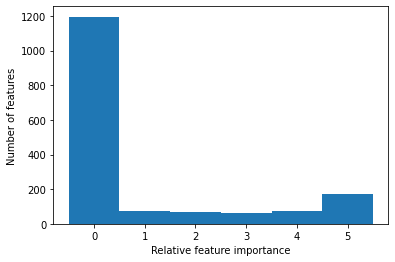

In [15]:
import matplotlib.pyplot as plt

feat_imp_ = np.sum(supports, axis=0)
plt.hist(feat_imp_, np.array(list(range(7)))-0.5)
plt.xlabel("Relative feature importance")
plt.ylabel("Number of features")

In [16]:
selected_feat_ind=np.any(supports,axis=0)
print(f"{np.count_nonzero(selected_feat_ind)} features selected out of {train_features.shape[1]}")

selected_features=all_features.iloc[:,selected_feat_ind]

454 features selected out of 1650


In [17]:
import dill as pickle
with open("AChEi_extended_selected_feat_ind.ob", "wb") as f:
    pickle.dump(selected_feat_ind, f)

In [25]:
all_target.to_csv("AChEi_extended_selected_target.csv")

In [ ]:
selected_features.to_csv("AChEi_extended_selected_feat.csv")

# Load data

In [40]:
import os, sys
import pandas as pd
import numpy as np

selected_features = pd.read_csv(
    "AChEi_extended_selected_feat.csv", index_col=0)
Fweights = pd.read_csv("AChEi_extended_selected_feat_Fweights.csv"
                      ).values
all_target=pd.read_csv("AChEi_extended_selected_target.csv", 
                       index_col=0).values.ravel()